This file will be used for some explinitory data analysis of the kings county data. This data set was provided to students of the flat iron school in order to implement a linear regression model.

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# necessary imports for eda will add as needed

In [307]:
df = pd.read_csv("..\data\kc_house_data.csv")
df.head() # inspecting our dataframe and seeing our columns and some basic values

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Notice that 'waterfront' and 'yr_renovated' appear to be the only columns with null values, however we shall further inspect these columns and see if this is in fact the case.


In [308]:
df.info() # notice that 'waterfront' and 'yr_renovated' and "view" appear to be the only columns with null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [309]:
df[["date", "yr_built", "yr_renovated", "waterfront", "view", "condition", "grade", "sqft_basement"]] # a subset of our dataframe with only the columns that need cleaning

,date,yr_built,yr_renovated,waterfront,view,condition,grade,sqft_basement
0,10/13/2014,1955,0.0,NaN,NONE,Average,7 Average,0.0
1,12/9/2014,1951,1991.0,NO,NONE,Average,7 Average,400.0
2,2/25/2015,1933,NaN,NO,NONE,Average,6 Low Average,0.0
3,12/9/2014,1965,0.0,NO,NONE,Very Good,7 Average,910.0
4,2/18/2015,1987,0.0,NO,NONE,Average,8 Good,0.0
...,...,...,...,...,...,...,...,...
21592,5/21/2014,2009,0.0,NO,NONE,Average,8 Good,0.0
21593,2/23/2015,2014,0.0,NO,NONE,Average,8 Good,0.0
21594,6/23/2014,2009,0.0,NO,NONE,Average,7 Average,0.0
21595,1/16/2015,2004,0.0,NaN,NONE,Average,8 Good,0.0


In [310]:
df["date"] = pd.to_datetime(df["date"]) #changing date column from string to datetime format

df["date"].min(), df["date"].max() #notice our dataset only includes data from one year

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

In [311]:
df.yr_renovated.fillna(0.0, inplace= True) # replacing NaN values with 0.0 in yr_renovated column

df.yr_renovated.isna().sum() # checking to see if there are any NaN values

0

In [312]:
df["sqft_basement"].replace(to_replace= "?", value = 0.0, inplace= True ) # replacing ? with 0.0 in our sqft_basement column

df["sqft_basement"] = df["sqft_basement"].astype("float")

In [313]:
df.waterfront.fillna("NO", inplace= True) #filling in NaN values with NO for waterfront
df.waterfront.eq('YES').mul(1) # now converting YES and NO to 1 and 0 respectively, this will help with our model fitting later
df.waterfront.describe()

count     21597
unique        2
top          NO
freq      21451
Name: waterfront, dtype: object

In [314]:
df.view.unique()
df.view.fillna("NONE", inplace = True)

Now it is time to move away from filling in our null values and correcting our data types and to begin dealing with our ordinal columns.

In [315]:
df["grade_num"] = df.grade.apply(lambda x: (int(x[0:2]))) # adding a grade numeric column which is derived from the grade column. Only using the integer grading.

In [316]:
from sklearn.preprocessing import OrdinalEncoder

ord_cat_selector = ['view', 'condition', 'grade_num'] # these three columns all have ordinal data and must be dealt with accordingly

cat_subset = df[ord_cat_selector]

cat_subset

,view,condition,grade_num
0,NONE,Average,7
1,NONE,Average,7
2,NONE,Average,6
3,NONE,Very Good,7
4,NONE,Average,8
...,...,...,...
21592,NONE,Average,8
21593,NONE,Average,8
21594,NONE,Average,7
21595,NONE,Average,8


In [317]:
cat_subset['view'].unique()
cat_subset['condition'].unique()
cat_subset['grade_num'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

In [318]:
view_list = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
#grade_list = ["3", "4", "5", "6", "7", '8', '9', '10', '11', '12', '13']
grade_list = [3,4,5,6,7,8,9,10,11,12,13]

In [319]:
o_enc = OrdinalEncoder(categories = [view_list, condition_list, grade_list])
o_enc.fit(cat_subset)

OrdinalEncoder(categories=[['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'],
                           ['Poor', 'Fair', 'Average', 'Good', 'Very Good'],
                           [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]])

In [320]:
X_subset = pd.DataFrame(o_enc.transform(cat_subset),
                        columns = cat_subset.columns)
#Merge with original dataframe
transformed_df =df.join(X_subset, rsuffix= "_ord")

transformed_df.drop(columns = ["id", "waterfront", "view", "condition", "grade", "grade_num", "zipcode", "lat", "long"], inplace= True)

In [321]:
transformed_df["age"] = 2015 - transformed_df["yr_built"] # adding an age column that gives us the total age of the home
transformed_df["yr_since_renov"] = 2015 - transformed_df["yr_renovated"] # adding a column that tells us how long ago if at all was the home renovated

<AxesSubplot:>

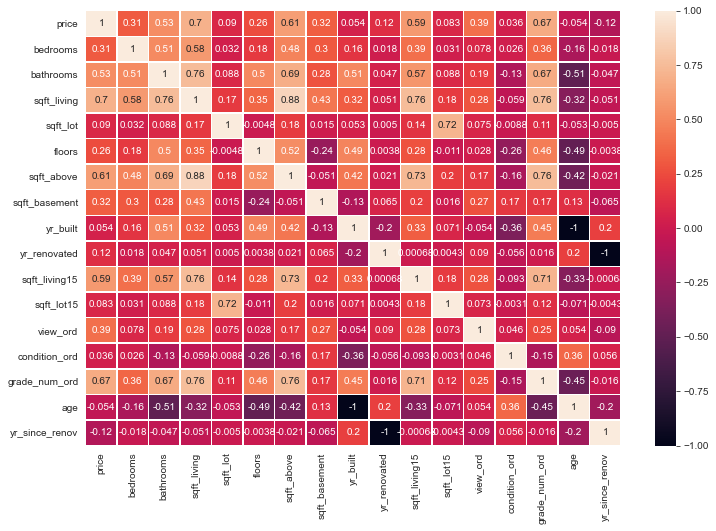

In [322]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(transformed_df.corr(), annot=True, linewidths=.5, ax=ax)

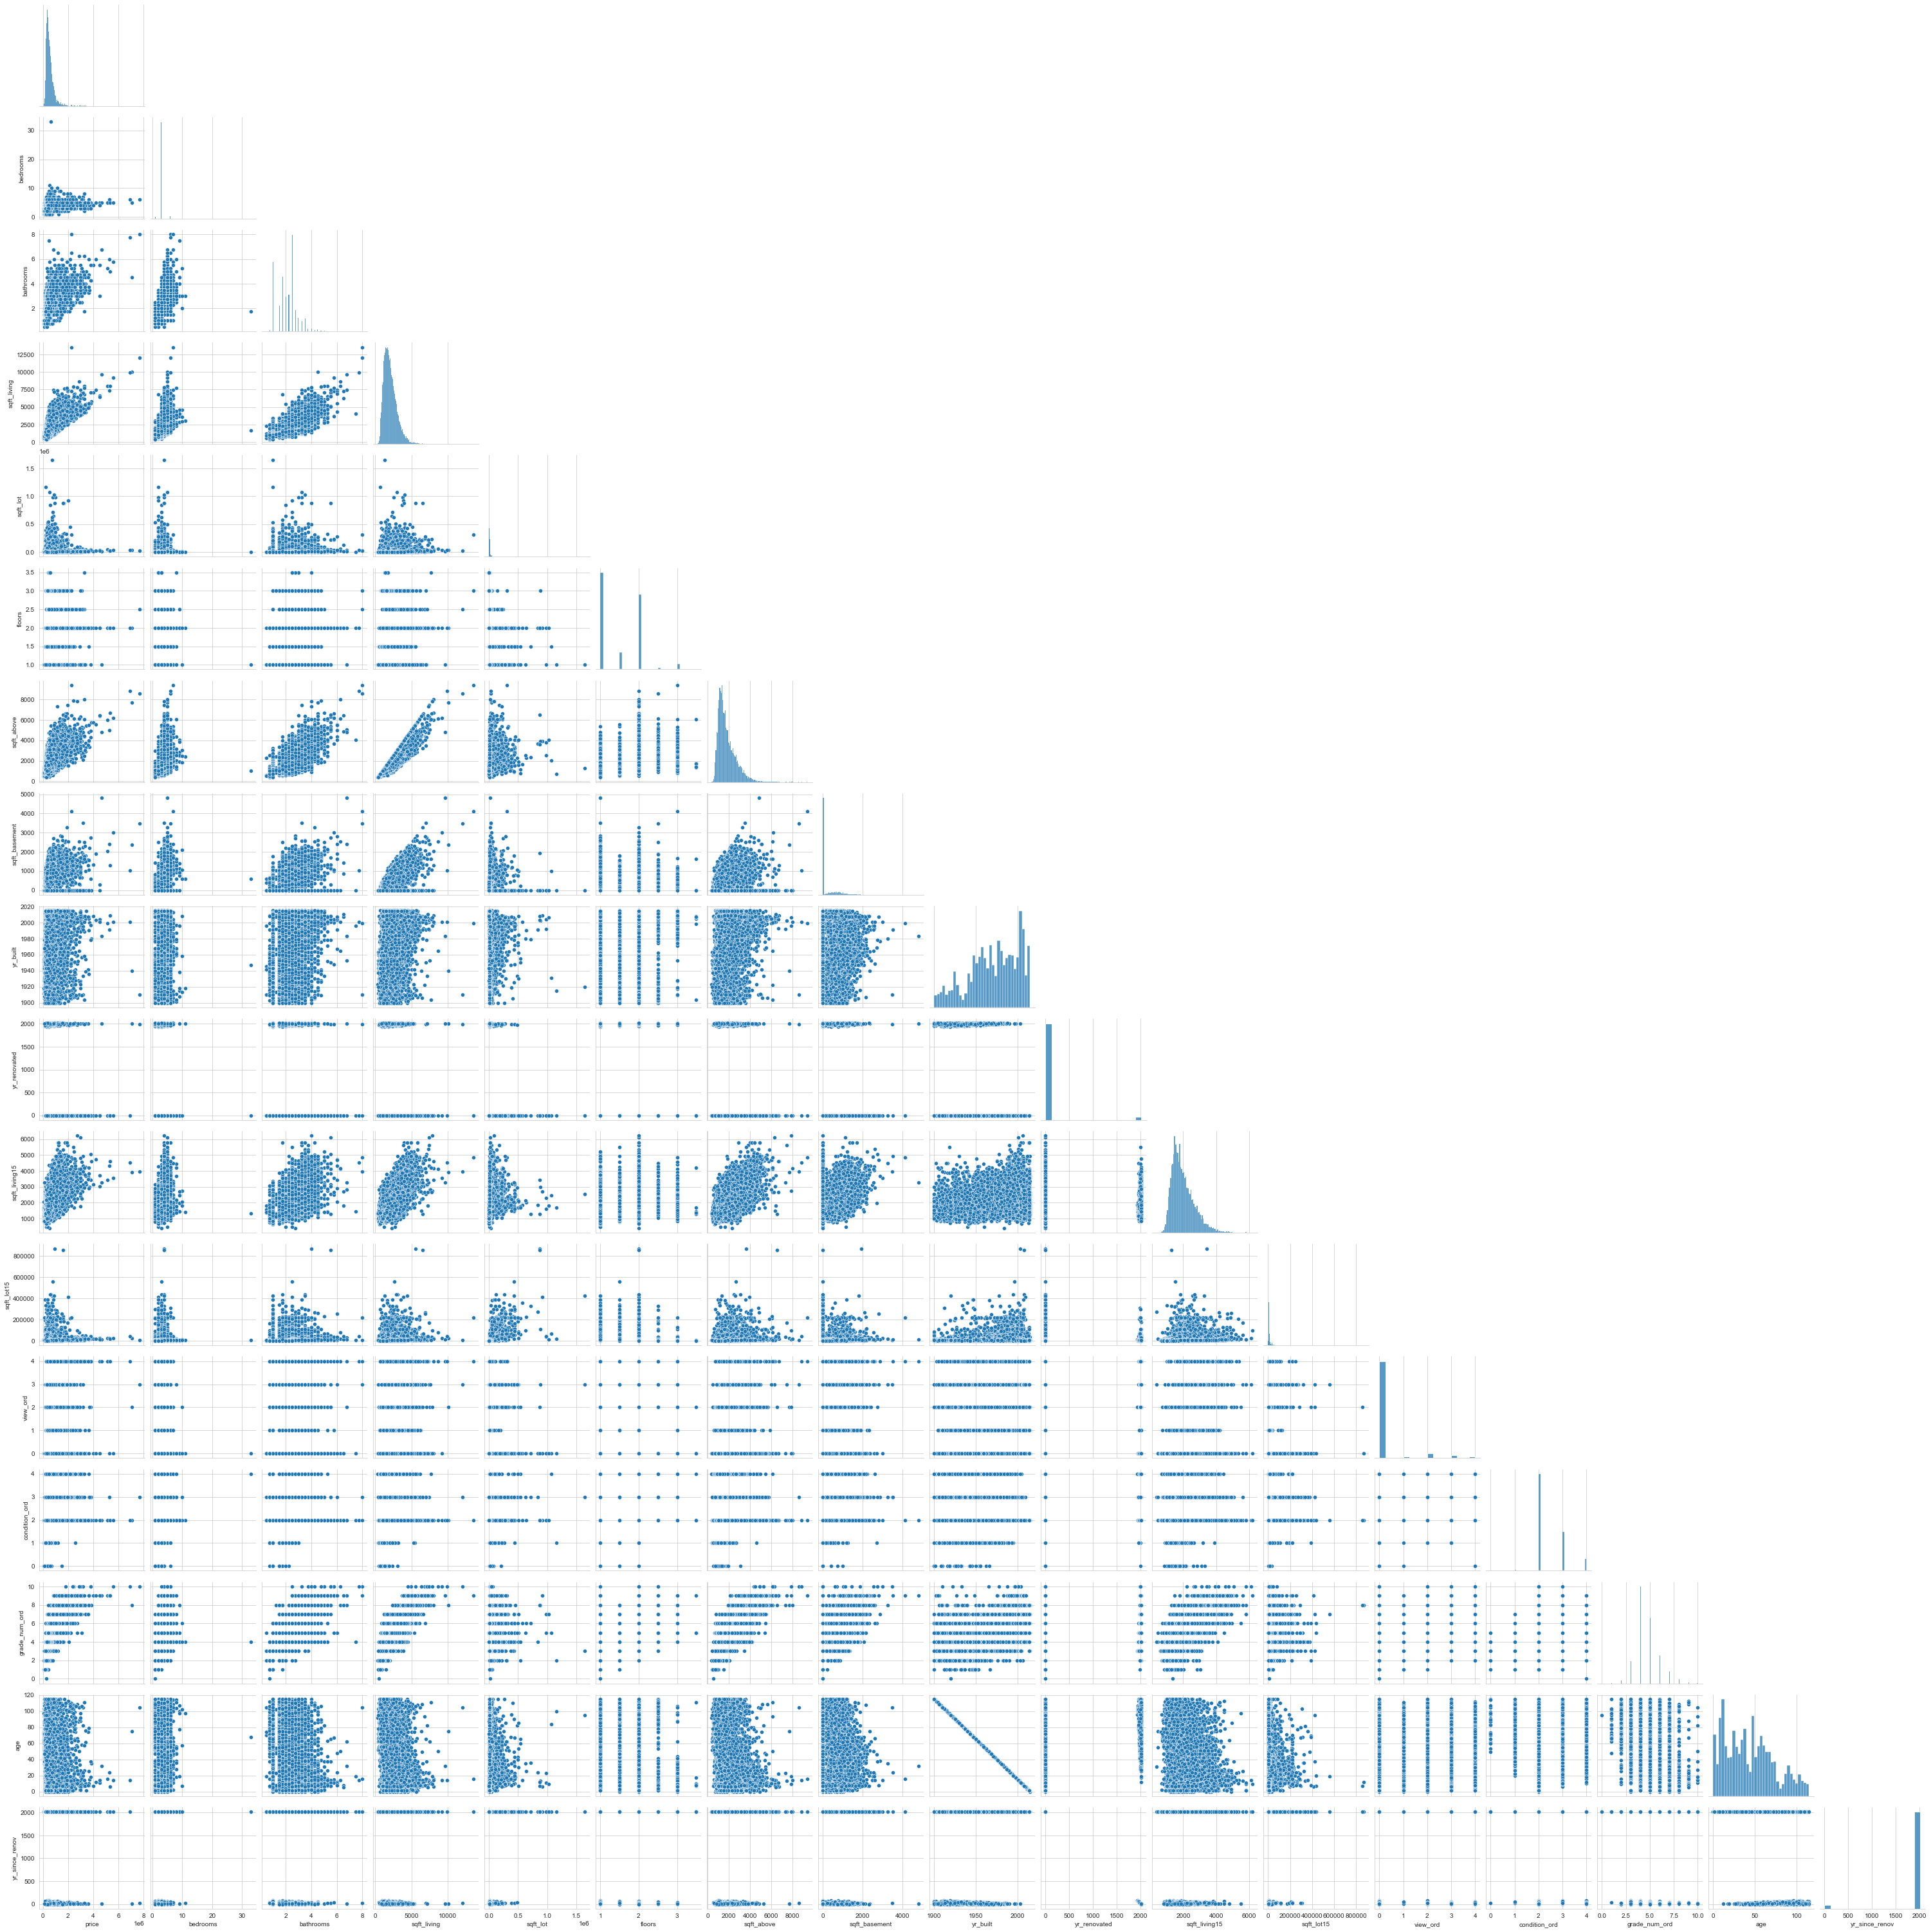

In [323]:
ax = sns.pairplot(transformed_df, corner = True)